# Using skorch with embeddings net for grid search

In [2]:
from shutil import rmtree
import IPython.display as ipd
import torch
from torch.utils.data import Dataset
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
import glob
import librosa
from scipy.io import wavfile
import pandas as pd
import os
from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetClassifier
from torch import nn
import torch.nn.functional as F
from tqdm import trange, tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from torch.optim.lr_scheduler import StepLR

In [11]:
# Preprocessing Data
def save_spectrogram_tisv(audio_path, tisv_frame=180, hop=0.01, window=0.0025, sr=8000, nfft=512, nmels=40):
    """ Full preprocess of text independent utterance. The log-mel-spectrogram is saved as numpy file.
        Each partial utterance is splitted by voice detection using DB
        and the first and the last 180 frames from each partial utterance are saved. 
        Need : utterance data set
    """
    print("start text independent utterance feature extraction")
    audio_path = glob.glob(os.path.dirname(audio_path))
    rmtree('./train_tisv/', ignore_errors=True)
    rmtree('./test_tisv/', ignore_errors=True)
    os.makedirs('./train_tisv', exist_ok=True)   # make folder to save train file
    os.makedirs('./test_tisv', exist_ok=True)    # make folder to save test file
    _no_sound_found = 0
    _minium_name_file_per_speaker = 10000
    utter_min_len = (tisv_frame * hop + window) * sr    # lower bound of utterance length
    total_speaker_num = len(audio_path)
    train_speaker_num= (total_speaker_num//10)*9            # split total data 90% train and 10% test
    print("total speaker number : %d"%total_speaker_num)
    print("train : %d, test : %d"%(train_speaker_num, total_speaker_num-train_speaker_num))
    for i, folder in enumerate(audio_path):
        print("%dth speaker processing..."%i)
        utterances_spec = []
        for utter_name in os.listdir(folder):
            if utter_name[-4:] == '.wav':
                utter_path = os.path.join(folder, utter_name)         # path of each utterance
                utter, sr = librosa.core.load(utter_path, sr)        # load utterance audio
                intervals = librosa.effects.split(utter, top_db=30)         # voice activity detection
                for interval in intervals:
                    if (interval[1]-interval[0]) > utter_min_len:           # If partial utterance is sufficient long,
                        utter_part = utter[interval[0]:interval[1]]         # save first and last 180 frames of spectrogram.
                        S = librosa.core.stft(y=utter_part, n_fft=nfft,
                                              win_length=int(window * sr), hop_length=int(hop * sr))
                        S = np.abs(S) ** 2
                        mel_basis = librosa.filters.mel(sr=sr, n_fft=nfft, n_mels=nmels)
                        S = np.log10(np.dot(mel_basis, S) + 1e-6)           # log mel spectrogram of utterances
                        utterances_spec.append(S[:, :tisv_frame])    # first 180 frames of partial utterance
                        utterances_spec.append(S[:, -tisv_frame:])   # last 180 frames of partial utterance

        utterances_spec = np.array(utterances_spec)
        if utterances_spec.shape[0] < 6:
            print(f"{i}th speaker {folder} not enough files")
            continue
        if utterances_spec.shape[0] < _minium_name_file_per_speaker:
            _minium_name_file_per_speaker = utterances_spec.shape[0]
        if i < train_speaker_num:
            np.save(os.path.join('./train_tisv', "speaker%d.npy" % i), utterances_spec)        
        else:
            np.save(os.path.join('./test_tisv', f"speaker{i-train_speaker_num}"), utterances_spec)
        print(utterances_spec.shape)

audio_path = '/storage/company_old/*/*.wav'
save_spectrogram_tisv(audio_path)

##### BUG
1. TypeError: 无法把网络放到gridsearch里面.
2. missing one parameter: embeddings in forward

In [12]:
# test get cossim
def get_cossim(embeddings, centroids):
    # number of utterances per speaker
    num_utterances = embeddings.shape[1]
    utterance_centroids = get_utterance_centroids(embeddings)

    # flatten the embeddings and utterance centroids to just utterance,
    # so we can do cosine similarity
    utterance_centroids_flat = utterance_centroids.flatten(0, 1)
    embeddings_flat = embeddings.flatten(0, 1)
    # the cosine distance between utterance and the associated centroids
    # for that utterance
    # this is each speaker's utterances against his own centroid, but each
    # comparison centroid has the current utterance removed
    cos_same = F.cosine_similarity(embeddings_flat, utterance_centroids_flat)
    # now we get the cosine distance between each utterance and the other speakers'
    # centroids
    # to do so requires comparing each utterance to each centroid. To keep the
    # operation fast, we vectorize by using matrices L (embeddings) and
    # R (centroids) where L has each utterance repeated sequentially for all
    # comparisons and R has the entire centroids frame repeated for each utterance
    centroids_expand = centroids.repeat((num_utterances * embeddings.shape[0], 1))
    embeddings_expand = embeddings_flat.unsqueeze(1).repeat(1, embeddings.shape[0], 1)
    embeddings_expand = embeddings_expand.flatten(0, 1)
    cos_diff = F.cosine_similarity(embeddings_expand, centroids_expand)
    cos_diff = cos_diff.view(embeddings.size(0),num_utterances,centroids.size(0))
    # assign the cosine distance for same speakers to the proper idx
    same_idx = list(range(embeddings.size(0)))
    cos_diff[same_idx, :, same_idx] = cos_same.view(embeddings.shape[0], num_utterances)
    cos_diff = cos_diff + 1e-6
    return cos_diff

In [13]:
def get_centroids(embeddings):
    centroids = embeddings.mean(dim=1)
    return centroids

def get_utterance_centroids(embeddings):
    """
    Returns the centroids for each utterance of a speaker, where
    the utterance centroid is the speaker centroid without considering
    this utterance

    Shape of embeddings should be:
    (speaker_ct, utterance_per_speaker_ct, embedding_size)
    这里(N, M, proj)->(N, k, proj)
    意思是对于每一个人(N), 求除了本身之外的utt的均值.
    例如, ouput.shape == (4, 3, 64), 那么一个对于output[0][0], 就是除了本身之外的另外两个的均值.
    """
    sum_centroids = embeddings.sum(dim=1)
    # we want to subtract out each utterance, prior to calculating the
    # the utterance centroid
    sum_centroids = sum_centroids.unsqueeze(1)
    # we want the mean but not including the utterance itself, so -1
    num_utterances = embeddings.shape[1] - 1
    centroids = (sum_centroids - embeddings) / num_utterances
    return centroids



def calc_loss(sim_matrix):
    same_idx = list(range(sim_matrix.size(0)))
    pos = sim_matrix[same_idx, :, same_idx]
    neg = (torch.exp(sim_matrix).sum(dim=2) + 1e-6).log_()
    per_embedding_loss = -1 * (pos - neg)
    loss = per_embedding_loss.sum()
    return loss, per_embedding_loss

In [14]:
class SpeakerDatasetTIMITPreprocessed(Dataset):
    
    def __init__(self, data_path, M, shuffle=True, utter_start=0):
        
        # data path
        self.path = data_path
        self.utter_num = M
        self.file_list = os.listdir(self.path)
        self.shuffle=shuffle
        self.utter_start = utter_start
        
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        
        np_file_list = os.listdir(self.path)
        
        if self.shuffle:
            selected_file = random.sample(np_file_list, 1)[0]  # select random speaker
        else:
            selected_file = np_file_list[idx]               
        
        utters = np.load(os.path.join(self.path, selected_file)) # load utterance spectrogram of selected speaker
        if self.shuffle:
            utter_index = np.random.randint(0, utters.shape[0], self.utter_num)   # select M utterances per speaker
            utterance = utters[utter_index]       
        else:
            utterance = utters[self.utter_start: self.utter_start+self.utter_num] # utterances of a speaker [batch(M), n_mels, frames]

        utterance = utterance[:,:,:160]               # TODO implement variable length batch size

        utterance = torch.tensor(np.transpose(utterance, axes=(0,2,1)))     # transpose [batch, frames, n_mels]
        return utterance

In [31]:
class SpeechEmbedder(nn.Module):
    
    def __init__(self, mels=40, hidden=128, num_layers=3, proj=64, N=4, M=6):
        super(SpeechEmbedder, self).__init__()    
        self.LSTM_stack = nn.LSTM(mels, hidden, num_layers=num_layers, batch_first=True)
        for name, param in self.LSTM_stack.named_parameters():
            if 'bias' in name: # 把bias初始化为0
                nn.init.constant_(param, 0.0)
            elif 'weight' in name: # weight用xavier初始化
                nn.init.xavier_normal_(param) # 这个说不定可以改变用uniform之类的
        self.projection = nn.Linear(hidden, proj)
        self.n = N
        self.m = M
        self.proj = proj
        
    def forward(self, x):
        x, _ = self.LSTM_stack(x.float()) #(batch, frames, n_mels) 这个是由于使用了batch_first=True
        #only use last frame
        x = x[:, -1] # [batch, hidden]
        x = self.projection(x) # [batch, projection] 
        x = F.normalize(x) # x.shape == [batch, projection]
        x = torch.reshape(x, (self.n, self.m, self.proj))
        return x

class GE2ELoss(nn.Module):
    
    def __init__(self, device):
        super(GE2ELoss, self).__init__()
        self.w = nn.Parameter(torch.tensor(10.0, device=device))
        self.b = nn.Parameter(torch.tensor(-5.0, device=device))

        
    def forward(self, X, **kwargs):
        torch.clamp(self.w, 1e-7) # 论文里面是0, 代码用的1e-7
        centroids = get_centroids(X)
        cossim = get_cossim(X, centroids)
        sim_matrix = self.w*cossim + self.b
        loss, _ = calc_loss(sim_matrix)
        return loss

PARMS: {'N': 16, 'lr': 0.001, 'epochs': 100, 'opt': 'Adam', 'debug': False}
lr: 0.001
lr: 0.001
0:258.0797
lr: 0.001
lr: 0.001
100:255.9811
lr: 0.001
lr: 0.001
200:226.0772
lr: 0.001
lr: 0.001
300:218.8512
lr: 0.001
lr: 0.001
400:240.0827
lr: 0.001
lr: 0.001
500:223.8030
lr: 0.001
lr: 0.001
600:220.4062
lr: 0.001
lr: 0.001
700:227.0639
lr: 0.001
lr: 0.001
800:224.8976
lr: 0.001
lr: 0.001
900:199.5142
lr: 0.001
lr: 0.001
1000:212.4568
lr: 0.001
lr: 0.001
1100:220.7292
lr: 0.001
lr: 0.001
1200:197.7689
lr: 0.001
lr: 0.001
1300:214.1790
TIME: 219.354 seconds


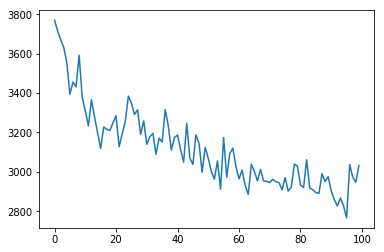

In [47]:
import time

# add timing for train
def logging(f):
    def _f(**kargs):
        print(f"PARMS: {kargs}")
        current = time.time()
        result = f(**kargs)
        print(f"TIME: {(time.time() - current):.3f} seconds")
        return result
    return _f

@logging
def train(N=16, lr=0.01, epochs=10, proj=256, hidden=768, num_layers=3, device='cuda', opt='SGD', debug=False, schedule=False):
    # define net, loss, optimizer
    device = torch.device(device)
    N = N
    M = 6
    embedder_net = SpeechEmbedder(hidden=hidden, num_layers=num_layers, proj=proj, N=N, M=M).to(device)
    criterion = GE2ELoss(device)
    if opt == 'Adam':
        optimizer = torch.optim.Adam([{'params': embedder_net.parameters()},
                                 {'params': criterion.parameters()}], lr=lr)
    elif opt == 'SGD':
        optimizer = torch.optim.SGD([{'params': embedder_net.parameters()},
                                    {'params': criterion.parameters()}], lr=lr)
    # print(f"Your optimizer is {optimizer}")
    # schedule
    if schedule:
        scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
    train_dataset = SpeakerDatasetTIMITPreprocessed('./train_tisv/', M)
    train_loader = DataLoader(train_dataset, batch_size=N, drop_last=True, shuffle=True)
    # print(len(train_loader))
    # train network
    epochs = epochs
    loss_log = []
    iteration = 0
    for e in range(epochs):
        if schedule:
            scheduler.step()
        epoch_loss = 0
        for batch_id, mel_db in enumerate(train_loader):
            # we have only 270 people the batch size is 1.
            mel_db = mel_db.to(device)
            mel_db = mel_db.flatten(0, 1)
            # mel_db = mel_db.reshape(N * M, mel_db.size(2), mel_db.size(3))
            optimizer.zero_grad()
            
            embeddings = embedder_net(mel_db)
            loss = criterion(embeddings)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            if iteration % 100 == 0:
                for param_group in optimizer.param_groups:
                    print(f"lr: {param_group['lr']}")
                print(f"{iteration}:{loss.item():.4f}")
            iteration +=1
        loss_log.append(epoch_loss)
    plt.plot(loss_log)
    if not os.path.exists('./models'):
        os.makedirs('./models')
    save_model_path = f'./models/lr{lr}epochs{epochs}proj{proj}hidden{hidden}num_layers{num_layers}opt{opt}.model'
    torch.save(embedder_net.state_dict(), save_model_path)
    return save_model_path, loss_log

# test loss printout
model_path, loss_log = train(N=16, lr=0.001, epochs=100, opt='Adam', debug=False)

# TEST

In [1]:
def test(model_path, **kargs):
    # test network
    N = 30
    M = 6
    test_dataset = SpeakerDatasetTIMITPreprocessed('./test_tisv/', M)
    test_loader = DataLoader(test_dataset, batch_size=N, drop_last=True, shuffle=True)
    embedder_net = SpeechEmbedder(40, kargs['hidden'], kargs['num_layers'], kargs['proj'], N, M//2)
    embedder_net.load_state_dict(torch.load(model_path))
    device = torch.device('cuda')
    embedder_net.to(device)
    embedder_net.eval()
    epochs = 10
    acc = 0 
    avg_EER = 0
    for e in range(epochs):
        batch_avg_EER = 0
        for batch_id, mel_db in enumerate(test_loader):
            mel_db = mel_db.to(device)
            utt_num = mel_db.shape[1]
            assert utt_num % 2 == 0
            enrollment, verification = torch.split(mel_db, utt_num // 2, dim=1)
            enrollment = embedder_net(enrollment.reshape(-1, mel_db.size(2), mel_db.size(3)))
            verification = embedder_net(verification.reshape(-1, mel_db.size(2), mel_db.size(3)))
            enrollment_centroids = get_centroids(enrollment)
            # what if verification get centorids
            sim_matrix = get_cossim(verification, enrollment_centroids) # N * M * proj
            
            # calculating EER
            diff = 1; EER=0; EER_thresh = 0; EER_FAR=0; EER_FRR=0
            
            for thres in [0.01*i+0.5 for i in range(50)]:
                sim_matrix_thresh = sim_matrix>thres
                
                FAR = (sum([sim_matrix_thresh[i].float().sum()-sim_matrix_thresh[i,:,i].float().sum() for i in range(int(N))])
                /(N-1.0)/(float(M/2))/N)
    
                FRR = (sum([M/2-sim_matrix_thresh[i,:,i].float().sum() for i in range(int(N))])
                /(float(M/2))/N)
                
                # Save threshold when FAR = FRR (=EER)
                if diff> abs(FAR-FRR):
                    diff = abs(FAR-FRR)
                    EER = (FAR+FRR)/2
                    EER_thresh = thres
                    EER_FAR = FAR
                    EER_FRR = FRR
            batch_avg_EER += EER
            print("EER : %0.2f (thres:%0.2f, FAR:%0.2f, FRR:%0.2f)"%(EER,EER_thresh,EER_FAR,EER_FRR))
            # calculating ACC
            verification = get_centroids(verification)
            result = cosine_distances(verification.detach().cpu().numpy(),enrollment_centroids.detach().cpu().numpy())
            batch_acc = sum(list(range(N)) == result.argmin(0)) / N
            acc += batch_acc
            print(f"BATCH ACC:{batch_acc}")
        avg_EER += batch_avg_EER/(batch_id+1)
    avg_EER = avg_EER / epochs
    return acc/10

In [45]:
# test phrase
test(model_path, proj=256, hidden=768, num_layers=3)

EER : 0.22 (thres:0.88, FAR:0.22, FRR:0.22)
BATCH ACC:0.3333333333333333
EER : 0.28 (thres:0.85, FAR:0.28, FRR:0.28)
BATCH ACC:0.36666666666666664
EER : 0.29 (thres:0.84, FAR:0.29, FRR:0.28)
BATCH ACC:0.2
EER : 0.23 (thres:0.86, FAR:0.24, FRR:0.22)
BATCH ACC:0.36666666666666664
EER : 0.27 (thres:0.87, FAR:0.26, FRR:0.28)
BATCH ACC:0.26666666666666666
EER : 0.22 (thres:0.87, FAR:0.23, FRR:0.21)
BATCH ACC:0.2
EER : 0.26 (thres:0.86, FAR:0.25, FRR:0.27)
BATCH ACC:0.2
EER : 0.27 (thres:0.89, FAR:0.26, FRR:0.28)
BATCH ACC:0.2
EER : 0.28 (thres:0.84, FAR:0.29, FRR:0.28)
BATCH ACC:0.4
EER : 0.26 (thres:0.89, FAR:0.27, FRR:0.26)
BATCH ACC:0.26666666666666666


0.27999999999999997

In [8]:
def pipeline(**params):
    # training
    model_path, total_loss = train(lr=params['lr'], 
                       epochs=params['max_epochs'], 
                       proj=params['proj'], 
                       hidden=params['hidden'], 
                       num_layers=params['num_layers'],
                        opt=params['opt'])
    plt.plot(total_loss)
    # testing
    acc = test(model_path, 
         proj=params['proj'], 
         hidden=params['hidden'], 
         num_layers=params['num_layers'])
    return acc

# test pipleline
pipeline(lr=0.01, max_epochs=30, proj=64, hidden=128, num_layers=3, opt='Adam')

NameError: name 'train' is not defined

In [3]:
# parameters sets
parameters = {
'max_epochs':[100],
'lr':[0.01],
'proj':[256],
'hidden':[768],
'num_layers':[3],
'opt':['SGD']
}
grid = ParameterGrid(parameters)
max_acc = 0
result = pd.DataFrame(grid)

for i, params in enumerate(grid):
    acc = pipeline(lr=params['lr'], max_epochs=params['max_epochs'], proj=params['proj'], 
                   hidden=params['hidden'], num_layers=params['num_layers'], opt=params['opt'])
    print(f"acc:{acc}")
    result.loc[i, 'acc'] = acc
    if acc > max_acc:
        max_acc = acc
        print(f"MAX ACC: {max_acc}")
        best_param = params
print(max_acc)
result.to_csv(f'jupyter_test_{ctime()}log.csv')

NameError: name 'pipeline' is not defined